In [139]:
from fastai.imports import *
import seaborn as sns
import graphviz
from pickle import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

# Dataset Preparation

In [140]:
df = pd.read_csv('./references/09 data clean.csv')
df.head()

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
0,7,1,17,3,3,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,1,1,1,1,1,2,1,0,3,3,2,0,3,1,1,3,1,16,4,0,3,3,3,3,1,2,2,17,4,1,3,2,3,3,3,1,2,3,1,2,3,3,1,3,2,1,1,3,1,1,42,1,1,1,1,1,2,2,2,2,2,1,2,2,1,0,0,0,0,0,0,0,0,0,1,1,1,3,0,0,0
1,9,1,15,1,5,1,4,1,1,3,3,7,4,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,2,,1,89,2,,2,1,1,3,0,3,2,3,2,2,1,3,17,4,0,1,0,3,1,0,2,1,8,2,0,4,0,3,4,1,4,0,0,4,0,4,2,4,2,4,0,2,0,2,4,44,1,2,,2,,,,,,,,,,,0,0,0,0,0,0,0,1,0,1,1,0,3,0,0,0
2,11,1,14,1,1,1,2,1,1,3,3,7,2,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,27,5,1,3,3,3,3,3,2,3,20,4,1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,80,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0
3,15,1,15,1,1,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,34,1,13,1,13,4,2,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,,2,,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,1,1,1,1,1,3,0,0,0
4,43,1,17,1,1,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,2,2,,2,,13,1,1,1,2,2,3,3,3,1,2,1,18,4,0,1,1,0,0,1,2,1,6,2,0,3,2,2,3,2,2,2,1,3,3,3,3,3,2,2,2,1,2,3,3,47,1,2,,1,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,1,1,1,1,1,3,0,0,0


In [141]:
cats=['religionnew', 'ethnicitynew', 'educationnew', 'occupationnew',
       'incomenew', 'maritalnew', 'smokenew', 'alcoholnew', 'partnernew',
       'EV', 'CB', 'PV', 'SV', 'IPV']
conts=['Age']
# dep="MINIdepression"
dep="Panxiety"
# dep="PPTSD"
for label in cats:
    df[label] = pd.Categorical(df[label])

In [142]:
df[dep].value_counts()

Panxiety
1    62
0    29
Name: count, dtype: int64

## Save all plot in figures

In [5]:
df_is_depress = df[(df[dep] == 1)]
df_is_depress.Age.describe()

count    62.000000
mean     17.741935
std       6.295810
min      12.000000
25%      15.000000
50%      16.000000
75%      18.750000
max      54.000000
Name: Age, dtype: float64

In [6]:
df_isnot_depress = df[(df[dep] == 0)]
df_isnot_depress.Age.describe()

count    29.000000
mean     19.034483
std       5.870524
min      13.000000
25%      16.000000
50%      17.000000
75%      19.000000
max      38.000000
Name: Age, dtype: float64

## Split Dataset

In [111]:
trn_df,val_df = train_test_split(df, test_size=0.25, stratify=df[dep])

In [115]:
trn_df[dep].value_counts()

Panxiety
1    46
0    22
Name: count, dtype: int64

In [116]:
val_df[dep].value_counts()

Panxiety
1    16
0     7
Name: count, dtype: int64

> The distribution between the dependent variable seem ok.

## Selecting Features

In [112]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [113]:
print(f'Training Shape: {trn_xs.shape}')
print(f'Validation Shape: {val_xs.shape}')

Training Shape: (68, 15)
Validation Shape: (23, 15)


> Bear in mind that the df is no longer categorical

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
trn_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
37,1,1,0,0,1,1,0,0,1,1,1,1,1,1,20
72,1,1,0,1,1,1,1,0,1,1,1,1,1,1,14
46,1,1,1,2,1,1,0,2,1,0,1,0,0,1,17
1,1,0,0,2,1,1,0,0,0,0,0,0,0,0,15
88,1,0,1,2,1,1,0,0,1,0,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1,1,1,2,1,1,0,0,1,1,1,0,1,1,16
86,1,1,1,0,1,0,0,0,1,0,1,1,0,1,37
17,1,1,1,2,1,1,0,0,1,0,1,0,1,1,16
66,1,1,1,1,1,1,0,0,1,0,1,0,1,1,19


In [14]:
trn_y

37    1
72    1
46    0
1     0
88    1
     ..
76    1
86    0
17    1
66    0
84    1
Name: Panxiety, Length: 68, dtype: int64

In [15]:
val_xs

,religionnew,ethnicitynew,educationnew,occupationnew,incomenew,maritalnew,smokenew,alcoholnew,partnernew,EV,CB,PV,SV,IPV,Age
40,1,1,1,2,1,1,0,0,1,1,1,0,1,1,14
11,1,1,0,1,1,1,1,2,1,1,1,0,0,1,14
9,1,1,1,1,1,1,0,0,1,0,1,0,1,1,15
24,1,1,1,2,0,1,0,0,1,0,1,0,0,1,16
73,1,1,0,2,1,1,0,0,1,1,1,0,1,1,21
28,1,1,1,2,1,1,0,0,1,1,1,0,0,1,17
50,0,0,0,2,1,1,0,0,1,1,1,0,1,1,17
22,1,0,0,1,0,1,1,1,1,1,1,0,0,1,12
38,1,1,1,1,1,1,0,2,1,1,1,0,1,1,14
64,1,1,1,2,0,1,0,2,1,1,1,1,1,1,16


In [16]:
val_y

40    1
11    1
9     1
24    1
73    1
28    1
50    1
22    1
38    1
64    1
25    0
62    1
14    1
82    0
7     1
79    1
51    0
6     0
18    0
70    1
78    1
13    0
90    1
Name: Panxiety, dtype: int64

In [138]:
val_y.index

Index([51, 74, 73, 66, 23, 48, 14, 76, 83, 38, 31, 15, 57, 12, 37, 88, 49,  3,
       63, 87,  2, 35, 20],
      dtype='int64')

# Logistic Regression

## Model Training and Prediction

In [114]:
logreg = LogisticRegression()
logreg.fit(trn_xs, trn_y)

LogisticRegression()

## Model Evaluation

### MAE For Validation Set

In [117]:
y_pred = logreg.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.30434782608695654

### MAE For Training Set

In [118]:
y_train_pred = logreg.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.27941176470588236

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

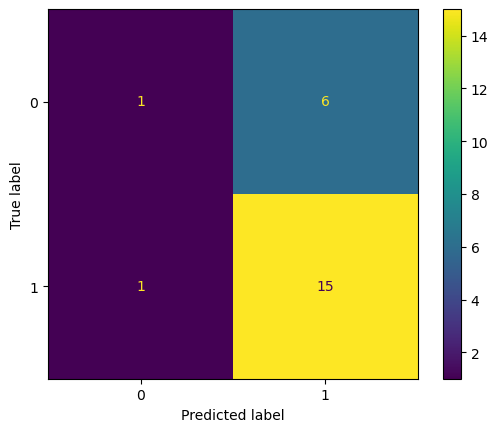

In [119]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not. If the purple boxes is more towards zero, the better it is since that means the model did never guessed wrong.

### Accuracy, Precision, Recall

In [21]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.631578947368421
Precision: 0.6875
Recall: 0.8461538461538461


Accuracy: In general, when the model makes prediction, it is right 57% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [22]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without Panxiety       0.33      0.17      0.22         6
   with Panxiety       0.69      0.85      0.76        13

        accuracy                           0.63        19
       macro avg       0.51      0.51      0.49        19
    weighted avg       0.58      0.63      0.59        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

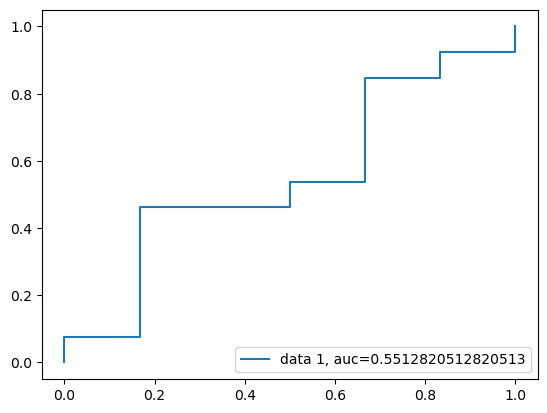

In [23]:
y_pred_proba = logreg.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.55. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.

### Feature Importance

#### By Training Set

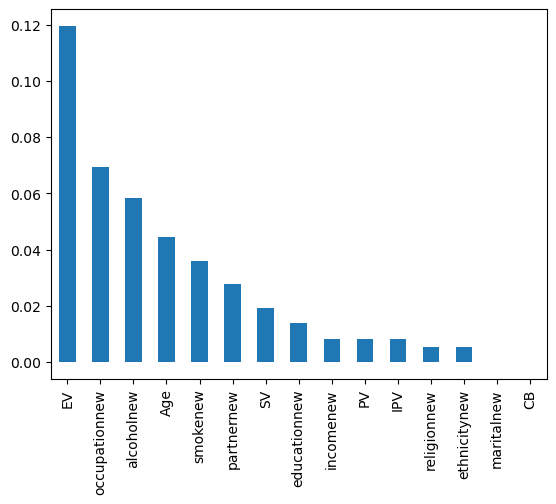

In [24]:
logreg_fi = permutation_importance(logreg, trn_xs, trn_y)
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(logreg_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.04 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

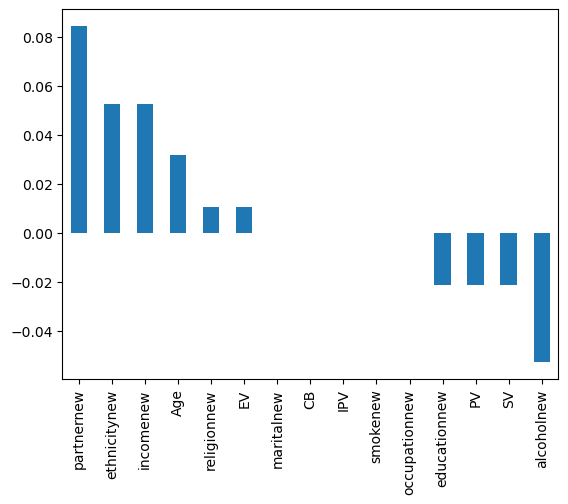

In [25]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

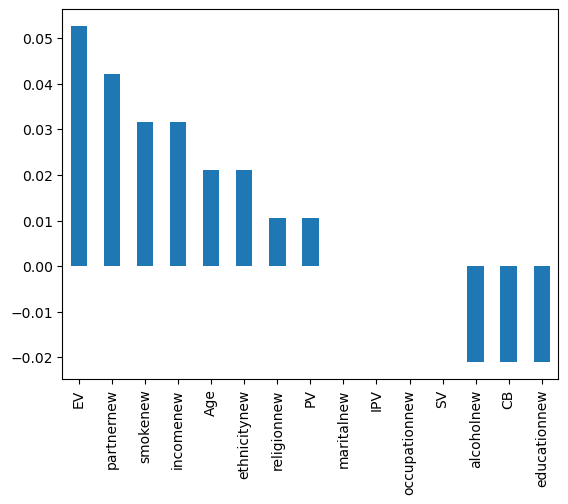

In [31]:
logreg_fi_val = permutation_importance(logreg, val_xs, val_y)

feature_importances = pd.Series(logreg_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

---

# Random Forest

## Model Training and Prediction

In [124]:
rf = RandomForestClassifier(100, min_samples_leaf=1)
rf.fit(trn_xs, trn_y)

RandomForestClassifier()

## Model Evaluation

### MAE For Validation Set

In [125]:
y_pred = rf.predict(val_xs)
mean_absolute_error(val_y, y_pred)

0.21739130434782608

### MAE For Training Set

In [126]:
y_train_pred = rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.0

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

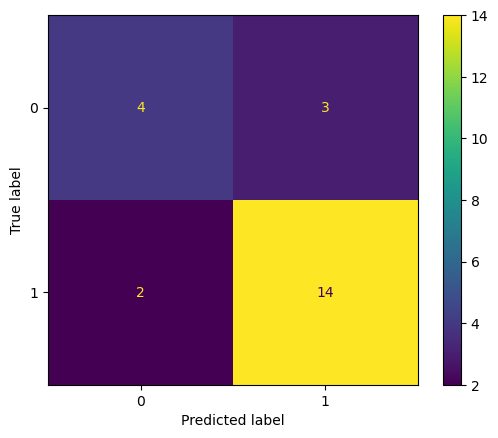

In [127]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is not very confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [128]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.782608695652174
Precision: 0.8235294117647058
Recall: 0.875


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

### Classification Report

In [129]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without Panxiety       0.67      0.57      0.62         7
   with Panxiety       0.82      0.88      0.85        16

        accuracy                           0.78        23
       macro avg       0.75      0.72      0.73        23
    weighted avg       0.78      0.78      0.78        23



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

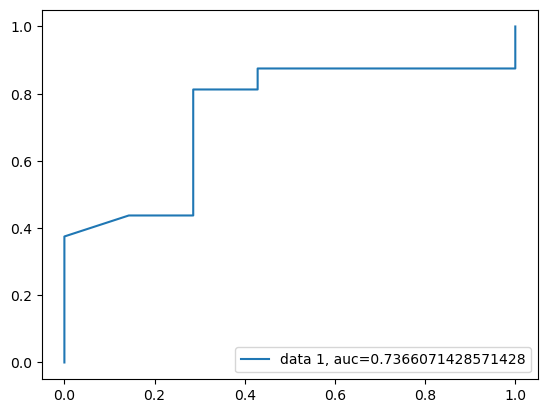

In [130]:
y_pred_proba = rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.56. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression

### Permutation Importance

#### By Training Set

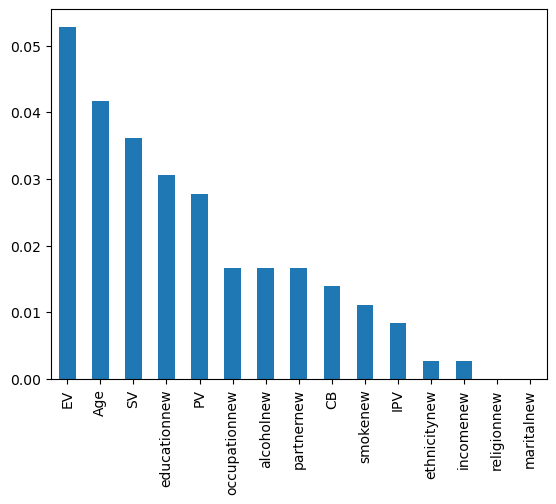

In [39]:
rf_fi = permutation_importance(rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_fi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.1 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

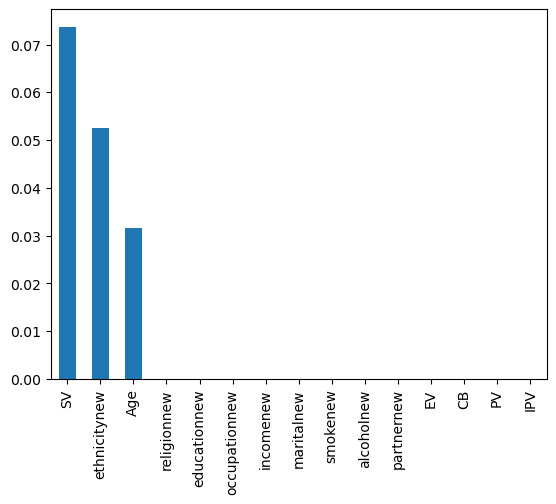

In [40]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

> Bear in mind that this model is not considered a good model by our Evaluation above (eg. AUC Score). So we cannot say for certain that the feature importance found above has a significant value to our conclusion. However we can still take it onto our consideration for further analysis.

> Also bear in mind, we get different result each time we refresh the code due to the randomness. However I found that EV is always on top of the other feature in importance.

#### Playground To Rerun

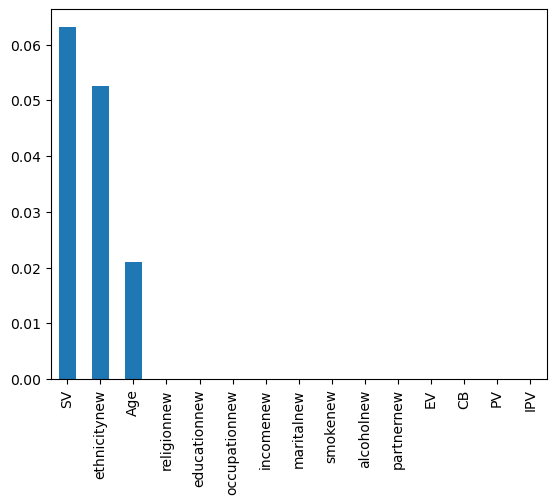

In [46]:
rf_fi_val = permutation_importance(rf, val_xs, val_y)

feature_importances = pd.Series(rf_fi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

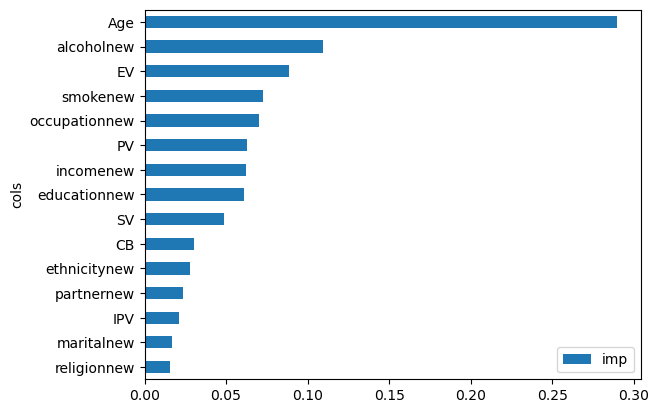

In [131]:
imp = rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

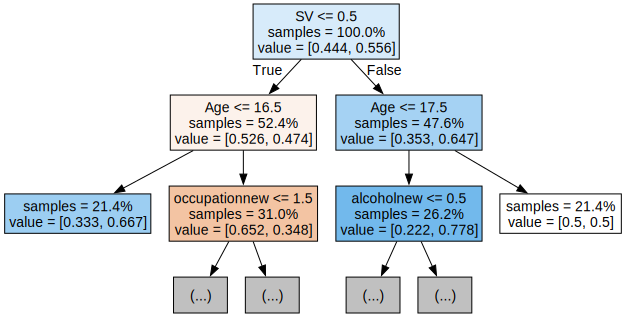

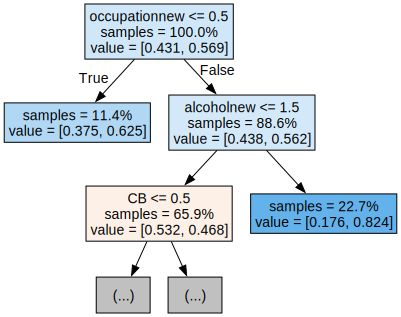

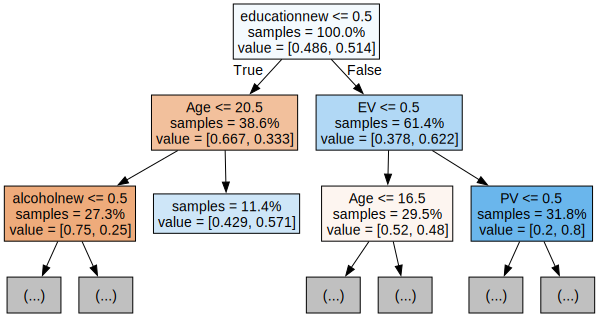

In [32]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Hyperparameter Tuning

In [50]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf2 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf2, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(trn_xs, trn_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018C026A7110>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000018C023E8710>})

In [51]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(val_xs)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 250}


### Model Evaluation

#### MAE For Validation Set

In [52]:
mean_absolute_error(val_y, y_pred)

0.3684210526315789

### MAE For Training Set

In [53]:
y_train_pred = best_rf.predict(trn_xs)
mean_absolute_error(trn_y, y_train_pred)

0.0

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

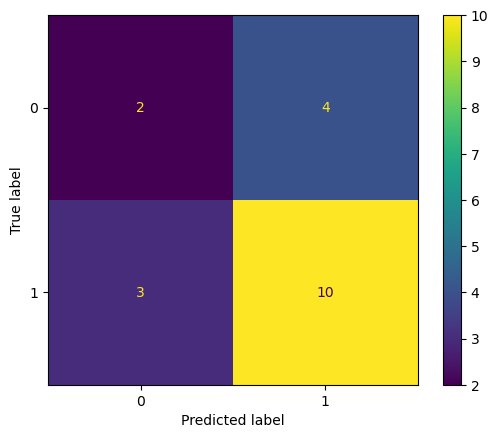

In [54]:
# Create the confusion matrix
cm = confusion_matrix(val_y, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is somewhat confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [55]:
accuracy = accuracy_score(val_y, y_pred)
precision = precision_score(val_y, y_pred)
recall = recall_score(val_y, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.631578947368421
Precision: 0.7142857142857143
Recall: 0.7692307692307693


### Classification Report

In [56]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without Panxiety       0.40      0.33      0.36         6
   with Panxiety       0.71      0.77      0.74        13

        accuracy                           0.63        19
       macro avg       0.56      0.55      0.55        19
    weighted avg       0.62      0.63      0.62        19



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

### ROC Curve

Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

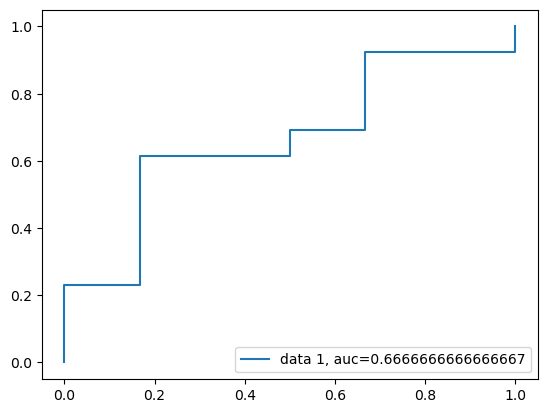

In [57]:
y_pred_proba = best_rf.predict_proba(val_xs)[:,1]
fpr, tpr, _ = roc_curve(val_y,  y_pred_proba)
auc = roc_auc_score(val_y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

> AUC score for the case is 0.53. AUC score 1 represents a perfect classifier, and 0.5 represents a worthless classifier.
> This is slighly better than the Logistic Regression?

### Permutation Importance

#### By Training Set

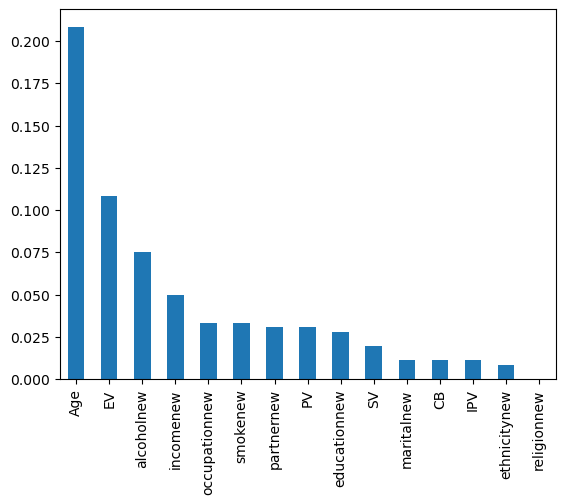

In [58]:
rf_pi = permutation_importance(best_rf, trn_xs, trn_y)

feature_importances = pd.Series(rf_pi['importances_mean'], index=trn_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

Where Y-axis is: Change in Mean Squared Error.

The left most means, changing this features will result in the RMSE to increase (about 0.16 for EV).
Meaning the model is highly dependent on these features.

Zero means changing the feature does not affect the model much.

X-axis is: Name of features in this model.

#### By Validation Set

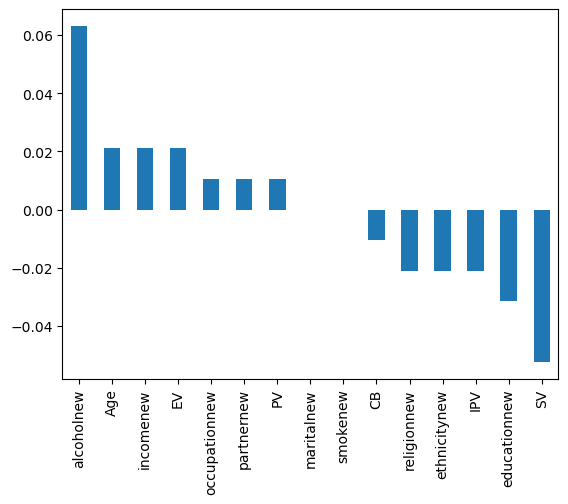

In [59]:
rf_pi_val = permutation_importance(best_rf, val_xs, val_y)

feature_importances = pd.Series(rf_pi_val['importances_mean'], index=val_xs.columns).sort_values(ascending=False)
feature_importances.plot.bar();

### Feature Importance

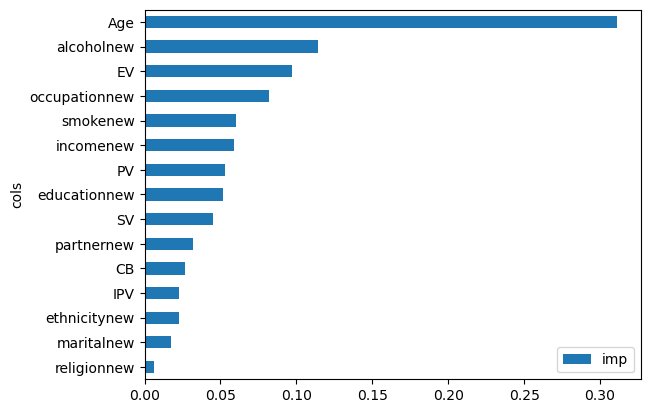

In [60]:
imp = best_rf.feature_importances_
pd.DataFrame(dict(cols=trn_xs.columns, imp=imp)).sort_values(by='imp', ascending=True).plot('cols', 'imp', 'barh');

> The bottom three feature is what we were expecting from the histogram where the sample is very small for one side.

### Visualizing the Results

We can use the following code to visualize our first 3 trees.

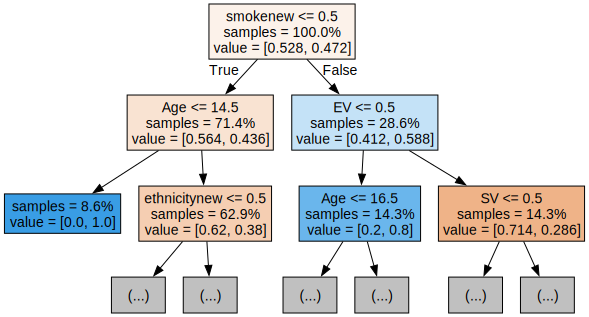

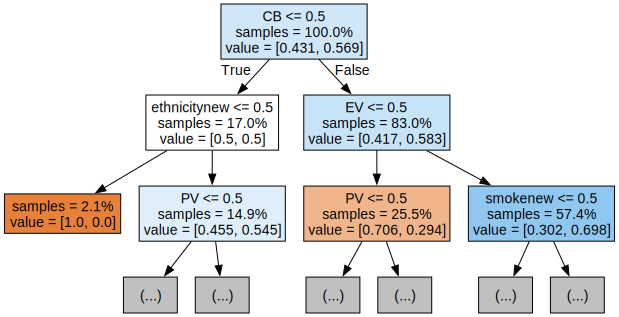

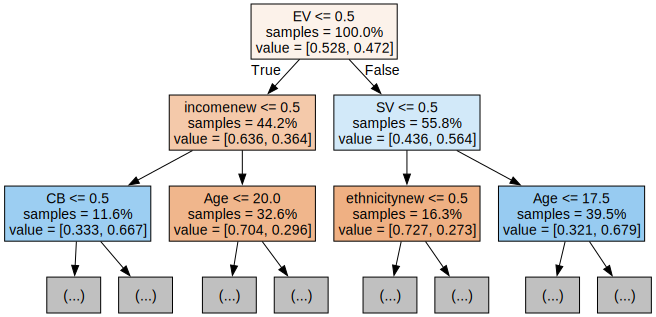

In [44]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trn_xs.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Saving The Model

## Loading The Model

---

# Finding p-value

## Using OLS

In [80]:
sm_X, sm_Y = xs_y(df)

In [81]:
sm_X2 = sm.add_constant(sm_X)

In [82]:
est = sm.OLS(sm_Y, sm_X2)

In [83]:
est2 = est.fit()

In [84]:
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Panxiety   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.249
Date:                Fri, 19 Jul 2024   Prob (F-statistic):              0.256
Time:                        15:42:04   Log-Likelihood:                -49.486
No. Observations:                  91   AIC:                             131.0
Df Residuals:                      75   BIC:                             171.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1387      0.769      1.481      0.143      -0.393       2.670
religionnew      -0.2238      0.308     -0.726      0.470      -0.837       0.390
ethnicitynew     -0.1557      0.229     -0.680      0.499      -0.612       0.300
educationnew     -0.0073      0.126     -0.058      0.954      -0.258       0.244
occupationnew    -0.0849      0.080     -1.055      0.295      -0.245       0.075
incomenew        -0.1314      0.134     -0.983      0.329      -0.398       0.135
maritalnew        0.0695      0.409      0.170      0.865      -0.745       0.884
smokenew         -0.1093      0.135     -0.809      0.421      -0.379       0.160
alcoholnew        0.0844      0.067      1.262      0.211      -0.049       0.218
partnernew        0.4106      0.281      1.463      0.148      -0.148       0.970
EV                0.2922      0.129      2.256      0.027       0.034       0.550
CB               -0.0323      0.259     -0.125      0.901      -0.548       0.483
PV                0.0099      0.130      0.076      0.939      -0.248       0.268
SV               -0.0374      0.125     -0.299      0.766      -0.286       0.212
IPV              -0.2684      0.353     -0.760      0.450      -0.972       0.436
Age              -0.0085      0.017     -0.496      0.621      -0.042       0.026
==============================================================================
Omnibus:                       16.284   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.617
Skew:                          -0.502   Prob(JB):                       0.0222
Kurtosis:                       2.000   Cond. No.                         346.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Using Logistic Regression

In [132]:
sm_X, sm_Y = xs_y(df)
a = dep + ' ~ '
for label in sm_X.columns:
    a += label + ' + '

formula = f'{dep} ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'
formula

'Panxiety ~ religionnew + ethnicitynew + educationnew + occupationnew + incomenew + maritalnew + smokenew + alcoholnew + partnernew + EV + CB + PV + SV + IPV + Age'

In [136]:
smf_model = smf.logit(formula, data=df).fit(maxiter=200)

Optimization terminated successfully.
         Current function value: 0.479449
         Iterations 103


In [137]:
smf_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Panxiety   No. Observations:                   91
Model:                          Logit   Df Residuals:                       73
Method:                           MLE   Df Model:                           17
Date:                Fri, 19 Jul 2024   Pseudo R-squ.:                  0.2339
Time:                        15:55:59   Log-Likelihood:                -43.630
converged:                       True   LL-Null:                       -56.954
Covariance Type:            nonrobust   LLR p-value:                   0.06342
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             42.1738        nan        nan        nan         nan         nan
religionnew[T.1]     -38.2127        nan        nan        nan         nan         nan
ethnicitynew[T.1]     -1.7976      1.440     -1.249      0.212      -4.619       1.024
educationnew[T.1]     -0.3802      0.711     -0.535      0.593      -1.774       1.014
occupationnew[T.2]    -1.5963      1.043     -1.530      0.126      -3.641       0.449
occupationnew[T.3]    -1.7416      1.084     -1.607      0.108      -3.866       0.383
incomenew[T.1]        -0.9771      0.797     -1.226      0.220      -2.539       0.585
maritalnew[T.1]        0.0782      0.825      0.095      0.925      -1.540       1.696
smokenew[T.1]         -1.0447      0.770     -1.357      0.175      -2.554       0.464
alcoholnew[T.1]       -0.8957      0.770     -1.163      0.245      -2.405       0.614
alcoholnew[T.2]        1.6588      0.945      1.756      0.079      -0.193       3.510
partnernew[T.1]        2.9790      1.466      2.032      0.042       0.106       5.852
EV[T.1]                1.6407      0.689      2.381      0.017       0.290       2.992
CB[T.1]               -0.2079      1.445     -0.144      0.886      -3.040       2.624
PV[T.1]                0.0460      0.775      0.059      0.953      -1.473       1.565
SV[T.1]               -0.1726      0.690     -0.250      0.802      -1.525       1.180
IPV[T.1]              -1.4207      1.763     -0.806      0.420      -4.877       2.035
Age                   -0.0578      0.024     -2.443      0.015      -0.104      -0.011
======================================================================================
"""

---

# FastAI Tabular Learner

## Model Training and Prediction

In [66]:
from fastai.tabular.all import *

In [67]:
splits = RandomSplitter()(df)

In [68]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cats,
    cont_names=conts,
    y_names=dep, y_block=CategoryBlock(),
).dataloaders(path='.')

In [143]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.12022644281387329, valley=0.004365158267319202)

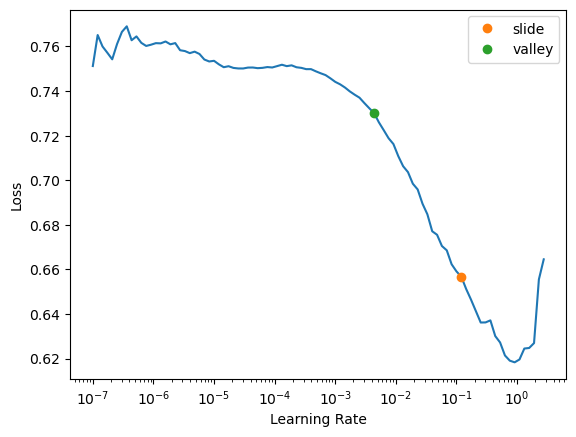

In [56]:
learn.lr_find(suggest_funcs=(slide, valley))

In [157]:
learn.fit(10, lr=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.369827,0.552276,0.722222,00:00
1,0.326997,0.543084,0.722222,00:00
2,0.323428,0.529990,0.722222,00:00
3,0.311576,0.523253,0.722222,00:00
4,0.317900,0.509218,0.722222,00:00
5,0.314824,0.497613,0.722222,00:00
6,0.313864,0.487253,0.722222,00:00
7,0.322147,0.483096,0.777778,00:00
8,0.319520,0.484262,0.777778,00:00
9,0.313655,0.491990,0.777778,00:00


In [158]:
trn_split,val_split=splits

In [159]:
df.iloc[val_split]

,ID,Home,Age,Religion,Ethnicity,Education,Occupation,Income,Marital,Smoke,Smoking,Alcohol,Partner,P_Age,P_Education,P_Occupation,P_Alcohol,P_Drugs,P_Fights,P_Women,P_Child,SectionCQ1,SectionCQ2,SectionCQ3,SectionCQ4,SectionCQ5,SectionCQ6,SectionCQ7,SectionCQ8,SectionCQ9,SectionCQ10,SectionCQ11,SectionCQ12,SectionCQ13,SectionCQ14,SectionCQ15,SectionCQ16,SectionCQ17,SectionCQ18,SectionCQ19,SectionCQ20,SectionCQ21,SectionCQ22,SectionCQ23,SectionCQ24,SectionCQ25,SectionCQ26,SectionCQ27,SectionCQ28,SectionCQ29,SectionCQ30,SectionCQ31,SectionCQ32,SectionCQ33,SectionCQ34,SectionCQ35,SectionCQ36,SectionCQ37,SectionCQ38,SectionCQ39,SectionCQ40,SectionCQ41,SectionCQ42,SectionCQ43,SectionCQ44,SectionDQ1,SectionDQ1a,SectionDQ2,SectionDQ2a,SectionDQ3,SectionDQ3a,SectionDQ4,SectionDQ5,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,PHQ10,TPHQ,LDEPRESSION,PDEPRESSION,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,TANXIETY,Lanxiety,Panxiety,PCL1,PCL2,PCL3,PCL4,PCL5,PCL6,PCL7,PCL8,PCL9,PCL10,PCL11,PCL12,PCL13,PCL14,PCL15,PCL16,PCL17,PCL18,PCL19,PCL20,TPCL,PPTSD,MINI1,MINI1a,MINI2,MINI2a,MINI3,MINI4,MINI5,MINI6,MINI7,MINI8,MINI9,MINI10,MINI11,MINIdepression,EV,CB,PV,SV,IPV,filter_$,religionnew,ethnicitynew,incomenew,maritalnew,educationnew,occupationnew,smokenew,alcoholnew,partnernew
25,37,1,17,1,1,2,2,1,1,2,2,7,5,18,3,1,6,5,2,2,2,1,1,1,1,2,2,2,1,2,1,1,1,1,2,1,2,1,2,2,3,1,1,2,3,1,2,2,3,2,3,2,3,2,3,2,3,1,2,3,4,4,4,4,5,1,2,2,,2,,3,4,0,3,3,3,1,1,0,1,1,1,13,3,0,0,1,0,0,1,3,1,6,2,0,1,2,3,3,2,2,0,0,1,1,1,1,2,2,4,3,1,3,1,3,36,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
67,80,2,17,1,1,2,4,1,1,3,2,3,5,22,2,1,6,5,2,2,2,1,1,1,1,2,2,2,2,2,1,2,2,1,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,1,1,1,2,3,3,2,2,4,1,789,1,7910,2,14,2,2,0,1,3,2,3,1,0,0,0,0,10,3,0,0,1,1,1,0,0,0,3,1,0,0,0,0,1,1,3,2,1,1,3,4,1,2,0,2,0,1,1,4,4,31,0,1,1,1,1,1,2,1,2,1,1,1,2,1,1,1,1,0,1,1,1,1,1,1,1,1,3,0,2,1
53,57,1,16,1,1,2,4,1,1,3,3,7,3,20,4,1,5,5,2,2,2,1,1,3,1,1,2,1,1,2,1,2,1,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,7,1,7,1,10,1,1,1,1,0,3,0,0,0,0,1,1,6,2,0,3,2,0,0,1,0,0,6,2,0,2,0,3,2,0,1,2,1,0,1,2,3,2,0,1,2,0,1,1,0,24,0,2,,2,,2,2,2,2,2,2,1,2,2,0,0,1,0,0,1,1,1,1,1,1,1,3,0,0,1
23,30,1,15,1,1,2,2,1,1,2,2,7,2,18,4,1,5,5,3,2,2,1,1,1,1,2,1,2,1,2,1,1,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,3,4,4,3,4,5,2,,2,,2,,2,1,3,3,1,1,3,3,3,3,3,0,23,5,1,3,3,3,3,3,3,2,20,4,1,4,4,4,4,4,4,2,2,4,3,4,4,4,4,4,2,0,1,4,3,65,1,1,1,1,1,2,1,2,2,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1
0,7,1,17,3,3,2,4,1,1,3,3,7,1,,6,6,7,7,4,5,6,2,2,2,2,1,2,2,2,2,2,2,2,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,2,3,3,4,4,4,4,5,1,1,1,1,1,1,2,1,0,3,3,2,0,3,1,1,3,1,16,4,0,3,3,3,3,1,2,2,17,4,1,3,2,3,3,3,1,2,3,1,2,3,3,1,3,2,1,1,3,1,1,42,1,1,1,1,1,2,2,2,2,2,1,2,2,1,0,0,0,0,0,0,0,0,0,1,1,1,3,0,0,0
37,52,1,20,1,1,3,2,1,1,3,3,7,2,19,3,4,5,5,3,3,2,3,3,1,1,3,2,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,1,1,2,3,2,3,1,1,2,3,1,1,2,2,2,2,1,1,1,1413,2,,2,,1,1,1,2,3,3,3,2,0,0,0,1,14,3,0,1,2,3,2,1,1,3,13,3,1,2,2,3,3,1,1,1,1,2,1,2,1,3,1,0,0,0,0,0,0,24,0,2,,2,,2,1,1,2,2,2,2,2,2,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1
80,46,1,21,1,1,2,2,1,1,3,1,6,5,29,2,1,5,6,1,2,2,1,1,1,2,4,1,2,1,2,1,1,2,1,1,1,1,1,1,2,3,2,3,1,1,2,3,2,3,2,3,2,3,1,1,1,1,2,3,2,3,3,3,3,4,1,2,2,,1,13,1,2,3,2,3,2,1,3,3,2,2,1,21,5,1,1,1,3,3,2,3,2,15,4,1,3,3,4,4,4,4,3,0,4,2,4,3,4,3,4,4,4,3,3,4,67,1,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
61,48,1,20,1,1,1,1,1,1,3,3,7,3,21,1,1,6,1,1,1,4,1,1,2,2,4,1,2,1,1,1,1,1,1,1,1,1,1,2,2,3,1,1,1,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,3,4,4,4,4,5,2,,2,,2,,1,1,2,3,3,3,2,2,3,1,0,2,19,4,0,3,2,2,3,2,3,2,17,4,1,1,3,1,4,3,3,3,2,4,2,4,3,4,4,4,3,3,4,3,4,62,1,1,1,1,1,2,1,1,1,1,1,2,2,2,0,1,1,1,1,1,1,1,1,1,1,0,2,0,0,1
70,84,2,16,1,1,2,4,1,1,3,1,2,5,23,3,1,3,5,1,3,2,2,2,1,1,2,2,2,2,2,1,1,2,2,3,1,2,2,3,1,2,2,3,2,3,2,3,2,3,2,3,2,3,1,2,1,2,1,2,2,3,3,3,3,4,1,23489,1,379,1,379,1,1,1,1,3,1,1,1,1,1,1,1,11,3,0,2,2,2,2,2,3,3,16,4,1,3,2,3,2,1,2,3,2,2,3,4,2,3,1,3,2,2,4,3,2,49,1,2,2,1,1,2,2,1,2,1,1,1,2,2,0,1,1,0,1,1,1,1,1,1,1,1,3,0,2,1
72,26

In [160]:
tst_dl = learn.dls.test_dl(df.iloc[val_split])

In [161]:
y_prob_ai, val_y_ai, y_pred_ai  = learn.get_preds(dl=tst_dl, with_decoded=True)

## Model Evaluation

### MAE For Validation Set

In [162]:
mean_absolute_error(val_y_ai, y_pred_ai)

0.2222222222222222

### MAE For Training Set

In [163]:
training_dl = learn.dls.test_dl(df.iloc[trn_split])
y_train_prob_ai, train_y_ai, y_train_pred_ai  = learn.get_preds(dl=training_dl, with_decoded=True)
mean_absolute_error(train_y_ai, y_train_pred_ai)

0.0821917808219178

> Lower MAE for training compare to validation set might indicate that the model is overfitting a little.

### Confusion Metrics

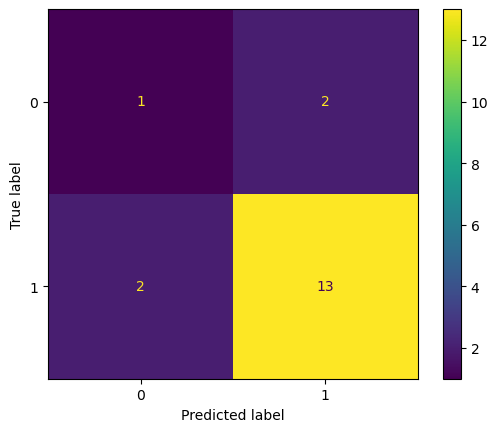

In [164]:
# Create the confusion matrix
cm = confusion_matrix(val_y_ai, y_pred_ai)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

> I will say that the model is fairly confidence in classifying if a subject is depressed or not.

### Accuracy, Precision, Recall

In [165]:
accuracy = accuracy_score(val_y_ai, y_pred_ai)
precision = precision_score(val_y_ai, y_pred_ai)
recall = recall_score(val_y_ai, y_pred_ai)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7777777777777778
Precision: 0.8666666666666667
Recall: 0.8666666666666667


Accuracy: In general, when the model makes prediction, it is right 63% of the time.

Precision: This is the accuracy of the Positive Prediction. For 60% precision for "with depression as positive", that means, for a list of patients that our model predicted as depressed, 60% of them IS in fact depressed, while the other 40% is not actually depressed but wrongly predicted as so. The downside is, it does not count missing POSITIVE, that is, our model can pick a few patients where it is confident that they are depressed and achieved High Precision, but left out many patients that are actually depressed but missed out by our model.

Recall: It is the ability of the model to detect the target. If there are 100 depressed patient in a list of X (let say 1000), and our model correctly labelled all 100 depressed patient as depressed, that means the recall is 100%. It does not matter if the model also predicted other non-depressed patient as depressed (False Positive), as it does not count in recall calculation. But too many False Positive can be inconvenient where manual intervention must be made to filter them out and make the labelling correct again.

In this case, with 100% precision, means for all those that this model predict as depressed, it is precisely all of them really are depressed. But with low recall meaning our model is missing (in this case 42%) other patients who are depressed but failed to be detected by our model.

### Classification Report

In [166]:
target_names = [f'without {dep}', f'with {dep}']
print(classification_report(val_y_ai, y_pred_ai, target_names=target_names))

                  precision    recall  f1-score   support

without Panxiety       0.33      0.33      0.33         3
   with Panxiety       0.87      0.87      0.87        15

        accuracy                           0.78        18
       macro avg       0.60      0.60      0.60        18
    weighted avg       0.78      0.78      0.78        18



F1 Score: makes a balance between precision and recall.

In the most simple terms, higher F1 scores are generally better. It range from 0 to 1.

## Saving The Model

## Load The Model

---